### DFRとVFRの未来の擾乱に対する計画収束速度で比較する

仮説: DFRで運行すると未来の擾乱に対する周りの人（自分の決定に影響を及ぼしうる人）の反応が瞬時にわかるため、VFRと比べた際に擾乱に対する収束速度が高まる。その結果として交通キャパシティが上昇する。

この仮説をシミュレーション実験によって確かめる。

#### 組むべき実験系


In [1]:
import random
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import pandas as pd
import sys
import copy

sys.path.append("../")
from models import Cars, ReservationTable
from utils import check_multiple_noise_effect, validate_with_ttc

In [2]:
# 初期設定（独立変数群）
CAR_NUM = 10 #時間窓内の車の総数
START_TIME = 0
TOTAL_LENGTH = 1000 # 入り口から出口までの距離 [m]
WAYPOINTS_NUM = 10 #constrained way pointの数
MEAN_SPEED = 20 # 秒速[m/s]として定義
TIME_STEP = 0.1
COMMUNICATION_SPEED = 0.1
TOTAL_TIME = 100
V_MAX = 40
GLOBAL_TIME_WINDOW = 60  # Strategic Phaseでの時間幅
TTC = 2 #車間時間を暫定的に定義


In [3]:
# 従属的に決まるもの
WAYPOINTS = [{"waypoint_idx": i, "x": TOTAL_LENGTH / WAYPOINTS_NUM * (i)} for i in range(WAYPOINTS_NUM+1)]
group_id = 0

arrival_times = sorted([random.uniform(0, GLOBAL_TIME_WINDOW) for _ in range(CAR_NUM)])
# arrival_times = [15.3, 27.1, 48.66, 54.83, 55.63]
CARS = [Cars(arrival_time=time, index=index, mean_speed=MEAN_SPEED)
              for index, time in enumerate(arrival_times)]

In [4]:
reservation_table = ReservationTable(waypoints = WAYPOINTS, global_params = {"DESIRED_TTC":TTC})
# 各車がETAを決める部分
for idx, car in enumerate(CARS):
    desired_eta_list = car.create_desired_eta(WAYPOINTS)
    is_valid = reservation_table.validate(desired_eta_list)
    if is_valid:
        reservation_table.register(desired_eta_list)
    else:
        calibration_info = {"desired_list": desired_eta_list}
        calibrated_list, _ = reservation_table.calibrate_list(**calibration_info)
        # print(calibrated_list)
        # print()
        df_to_add = pd.DataFrame(calibrated_list)
        reservation_table.register(calibrated_list)



In [5]:
# cwp_table.waypoint_table
def create_noise(**kwargs):
    start_time = kwargs.get("time_step")
    TOTAL_LENGTH = kwargs.get("TOTAL_LENGTH")
    if start_time == None or TOTAL_LENGTH == None:
        raise ValueError("start_time, TOTAL_LENGTHが入力されていません")
    expected_noise_period = kwargs.get("expected_noise_period",10)
    return {"x":[610, 730], "t":[40,50]}
    
    

#### ここからノイズを入れたシミュレーションを開始

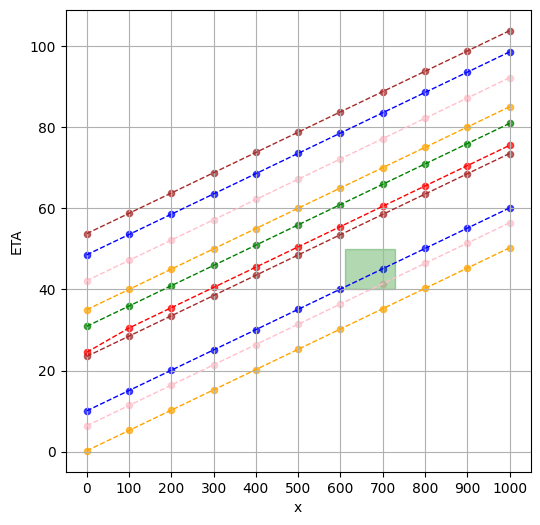

In [6]:
initial_cwp = copy.deepcopy(reservation_table)
noise = create_noise(time_step=20,TOTAL_LENGTH=1000)
reservation_table.plot_with_noise([noise])


### シミュレーションの流れ

各時刻において以下の計算を行う
1. ノイズ発生フェーズ: ある時刻にもしノイズがなければ一定確率で発生させる
2. 情報更新フェーズ

   ノイズ発生フェーズで生じたノイズと、直前の時刻での情報更新に基づいて影響を受ける車を列挙.
   
   `reactive_cars`に格納
4. `reactive_cars`の先頭車がノイズに反応(処理としては`cars.react_to_noise()`).

   `cwp_table`を書き換える
6. 今の状態で一歩前進

In [16]:
class DFRSimulation:
    def __init__(self,  **kwargs):
        # シミュレーションのベース諸元
        self.TOTAL_TIME = kwargs.get("TOTAL_TIME")
        self.TIME_STEP = kwargs.get("TIME_STEP")
        self.ONE_SEC_STEP = int(1/TIME_STEP)
        self.total_steps = int(TOTAL_TIME / TIME_STEP)
        self.TOTAL_LENGTH = kwargs.get("TOTAL_LENGTH")

        # 他モデルのインポート   
        self.CARS = kwargs.get("CARS")
        self.reservation_table = kwargs.get("reservation_table")

        # ノイズ関係の諸元
        self.NOISE_PROBABILITY = kwargs.get("NOISE_PROBABILITY")
        self.FUTURE_SCOPE = kwargs.get("FUTURE_SCOPE") # だいたい何秒先のノイズならわかるか、に相当する数字.
        self.MEAN_NOISE_PERIOD = kwargs.get("MEAN_NOISE_PERIOD") # だいたい何秒先のノイズならわかるか、に相当する数字.

    
        
    def conduct_simulation(self):
        current_noise = []
        for i in range(self.total_steps):
            time = i * TIME_STEP
        
            """
            STEP 1. ノイズが来るかを判定
            1秒に一回 and 現在のノイズがなかったら、
            NOISE_ARRIVAL_PROBに基づいてノイズを発生させる. 
            """
            if i % self.ONE_SEC_STEP == 0 and len(current_noise) < 1:
                new_noise = self.create_noise(time)
                current_noise.append(new_noise)

            """
            STEP 2. ノイズの影響を受ける車と、ノイズによって影響を受けた他の車の影響を受けた車をリスト化
            """
            influenced_by_noise_cars = self.find_noise_influenced_cars(current_noise)
            influenced_by_eta_cars = self.find_ETA_influenced_cars()
            influenced_cars = list(set(influenced_by_noise_cars + influenced_by_eta_cars))

            print(f"対象車: {influenced_cars}")

            if len(influenced_cars) > 0: # ETA変更する車が存在した場合.
                """
                STEP 3. 続いて影響されるうち先頭の車のETAをupdateする. 
                (a) ノイズ由来での進路変更の場合 => ノイズだけを気にすればよい. 
                (b) 他の車由来での進路変更 => 前の車だけを気にすればよい. 
                (c) 両方の影響を受けた時 => 前の車だけを気にすればよい.
                """
                car_to_action_id = min(influenced_cars)
                car_to_action = self.CARS[car_to_action_id]
                if not car_to_action_id in [influenced_by_eta_cars]: # 先頭車がノイズの影響だけを受けている場合
                    new_eta = car_to_action.avoid_noise(noiseList=current_noise, table=self.reservation_table, current_time=current_time)
                else: 
                    new_eta = car_to_action.consider_others(table=self.reservation_table)
                reservation_table.update_with_request(car_idx=car_to_action_id, new_eta=new_eta)
                    
            """
            STEP 4. 全員前進. 
            """
            for car in CARS:
                car.proceed()

    def find_noise_influenced_cars(self, noiseList):
        car_list = [idx for idx,car in enumerate(self.CARS) if check_multiple_noise_effect(noiseList, car.eta_table)]
        return car_list

    def find_ETA_influenced_cars(self):
        eta_reservation_table = self.reservation_table.eta_table
        TTC = self.reservation_table.global_params.DESIRED_TTC
        car_list = [idx for idx,car in enumerate(self.CARS) if validate_with_ttc(eta_reservation_table, car.eta_table, TTC)]
        return car_list

                

    def plot_history(self):
        """
        各車のETAの変更履歴、座標、ノイズの有無をプロットする。
        """
        return
    
            

            

    def create_noise(self, current_time):
        return {"x":[610, 730], "t":[40,50]}

In [17]:
simulation = DFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, CARS = CARS, \
                          reservation_table = reservation_table)
print(len(simulation.CARS))
simulation.conduct_simulation()

10
対象車: [1, 2]


AttributeError: 'Cars' object has no attribute 'plan_new_eta'

In [14]:
min([1])

1

In [20]:
def generate_random_number(center, size=1):
    std_dev = (center * 0.10) / 2 # 標準偏差を設定. 
    random_numbers = np.random.normal(center, std_dev, size)

    return random_numbers

In [11]:
df = cwp_table.waypoint_table
new_eta = [10] * 11
cwp_table.update_with_request(car_idx=0, new_eta=new_eta)
cwp_table.waypoint_table

11


,waypoint_idx,x,eta,car_idx
0,0,0.0,1.697172,1
1,1,100.0,8.569804,1
2,2,200.0,13.569804,1
3,3,300.0,18.569804,1
4,4,400.0,23.569804,1
...,...,...,...,...
105,6,600.0,10.000000,0
106,7,700.0,10.000000,0
107,8,800.0,10.000000,0
108,9,900.0,10.000000,0


In [12]:
"""
noiseの影響範囲にあたっている車はETAの変更を行う。
"""
for idx, car in enumerate(CARS):
    desired_eta_list = car.create_desired_eta(WAYPOINTS)
    is_valid = cwp_table.validate(desired_eta_list)
    if is_valid:
        cwp_table.register(desired_eta_list)
    else:
        calibration_info = {"desired_list": desired_eta_list}
        calibrated_list, _ = cwp_table.calibrate_list(**calibration_info)
        # print(calibrated_list)
        # print()
        df_to_add = pd.DataFrame(calibrated_list)
        cwp_table.register(calibrated_list)

In [12]:
car = CARS[1]
print(car.eta_table)

def check_noise_effect(noiseList, eta_table):
    return [check_single_noise_effect(noise, eta_table) for noise in noiseList]

def check_single_noise_effect(noise, eta_table):
    """
    returns if the ETAs will be blocked by the noise.
    waypoint間は等速で車が動くものと仮定している. 
    """
    print(noise)
    noise_x_range = noise["x"]
    noise_t_range = noise["t"]
    waypoint_x_list = [wp["x"] for wp in eta_table]
    waypoint_eta_list = [wp["eta"] for wp in eta_table]
    for i, x_coor in enumerate(waypoint_x_list):
        if i >= len(waypoint_x_list) -1: # 一番最後のwaypointに来た時
            return False
            
        x1, x2 = waypoint_x_list[i], waypoint_x_list[i+1]
        t1, t2 = waypoint_eta_list[i], waypoint_eta_list[i+1]
        # print(f"(x1,t1)=({x1}, {t1})")
        if (x1 < noise_x_range[0] and x2 < noise_x_range[0]) or (x1 > noise_x_range[1] and x2 > noise_x_range[1]):
            continue  # Both points are on the same side of the x range
        if (t1 < noise_t_range[0] and t2 < noise_t_range[0]) or (t1 > noise_t_range[1] and t2 > noise_t_range[1]):
            continue
        if x1 != x2:
            slope = (t2 - t1) / (x2 - x1)
            t_at_x_min = t1 + slope * (noise_x_range[0] - x1)
            t_at_x_max = t1 + slope * (noise_x_range[1] - x1)
            # print(f"{slope} = ({t2} - {t1}) / ({x2} - {x1})")
            # print(f"{t_at_x_min} = {t1} + {slope} * ({noise_x_range[0]} - {x1})")
            if (noise_t_range[0] <= t_at_x_min <= noise_t_range[1]) or (noise_t_range[0] <= t_at_x_max <= noise_t_range[1]):
                return True    

car_list = [idx for idx,car in enumerate(CARS) if check_single_noise_effect(noise, car.eta_table)]
print(car_list)

[{'waypoint_idx': 0, 'x': 0.0, 'eta': 6.401713970409634, 'car_idx': 1}, {'waypoint_idx': 1, 'x': 100.0, 'eta': 11.401713970409634, 'car_idx': 1}, {'waypoint_idx': 2, 'x': 200.0, 'eta': 16.401713970409634, 'car_idx': 1}, {'waypoint_idx': 3, 'x': 300.0, 'eta': 21.401713970409634, 'car_idx': 1}, {'waypoint_idx': 4, 'x': 400.0, 'eta': 26.401713970409634, 'car_idx': 1}, {'waypoint_idx': 5, 'x': 500.0, 'eta': 31.401713970409634, 'car_idx': 1}, {'waypoint_idx': 6, 'x': 600.0, 'eta': 36.40171397040963, 'car_idx': 1}, {'waypoint_idx': 7, 'x': 700.0, 'eta': 41.40171397040963, 'car_idx': 1}, {'waypoint_idx': 8, 'x': 800.0, 'eta': 46.40171397040963, 'car_idx': 1}, {'waypoint_idx': 9, 'x': 900.0, 'eta': 51.40171397040963, 'car_idx': 1}, {'waypoint_idx': 10, 'x': 1000.0, 'eta': 56.40171397040963, 'car_idx': 1}]
{'x': [610, 730], 't': [40, 50]}
{'x': [610, 730], 't': [40, 50]}
{'x': [610, 730], 't': [40, 50]}
{'x': [610, 730], 't': [40, 50]}
{'x': [610, 730], 't': [40, 50]}
{'x': [610, 730], 't': [40

### ここから下はDebug用のセル

In [6]:
# Initialize
car_0 = CARS[0]
print(arrival_times)
car_0.arrival_time

[1.1514412675820007, 20.670029824891007, 21.993481994314482, 30.18365737679346, 35.091883812613865, 45.16063044492818, 46.75884290964873, 52.515749460062686, 52.90767092789682, 58.33068176234094]


1.1514412675820007